In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
def cal_area_quad(center_a,center_b,d,theta_l,theta_r,R):
    a,b = center_a,center_b
    hl = R*tf.sin(theta_l)+center_b
    hr = R*tf.sin(theta_r)+center_b
    r = np.sqrt(pow((0.0 - a),2) + pow((hl - b),2))

    def f(x):
        return np.sqrt(pow(r,2)-pow(x-a,2))+b

    area = sp.integrate.quad(f, 0, d)

    # (x-a)^2 + (y-b)^2 = r^2

    return area

In [18]:
def cal_area_theta(center_a,center_b,d,theta_l,theta_r,R):

    a = center_a
    b = center_b
    hl = R*tf.sin(theta_l)+center_b
    hr = R*tf.sin(theta_r)+center_b
    r = R
    theta = theta_l - theta_r
    point_1 = (hl * a) / (hl - b)
    point_2 = d + (a - d) * hr / (hr - b)
    fan_shape = 0.5 * theta * (pow(r,2))
    triangle_1 = 0.5 * (0-point_1) * hl
    triangle_2 = 0.5 * (d - point_2) * hr
    triangle_3 = 0.5 * (point_2 - point_1) * b
    area = fan_shape - triangle_1 + triangle_2 - triangle_3
    # print(f'theta_1: {math.degrees(theta_1)} theta_2: {math.degrees(theta_2)} theta: {math.degrees(theta)}')

    return area

In [2]:
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

# Define contact line velocity
# theta_0 : equilibrium contact angle
# theta_d : dynamic contact angle
def fun_contact_line_velocity( f_c,i_t,theta_0, theta_d ):
    one = tf.constant(1, dtype=tf.float64)
    return -f_c*i_t*(-tf.cos(theta_0)+tf.cos(theta_d))

# Set constants
pi = tf.constant(np.pi, dtype=tf.float64)
p_f_c = tf.constant(-2.02, dtype=tf.float64) # positive_friction_coefficient
n_f_c = tf.constant(-5.64, dtype=tf.float64) # nagative_friction_coefficient
i_t = tf.constant(7.6408/1000, dtype=tf.float64) #interfacial tension between the two liquids
d = tf.constant(0.321/1000, dtype=tf.float64) #gab

thetal_0 = tf.constant(np.deg2rad(94), dtype=tf.float64)
thetal_d = tf.constant(np.deg2rad(55), dtype=tf.float64)
thetar_0 = tf.constant(np.deg2rad(59), dtype=tf.float64)
thetar_d = tf.constant(np.deg2rad(109), dtype=tf.float64)

vl = tf.constant(fun_contact_line_velocity(n_f_c ,i_t,thetal_0, thetal_d ), dtype=tf.float64)
vr = tf.constant(fun_contact_line_velocity(p_f_c ,i_t,thetar_0 , thetar_d ), dtype=tf.float64)

# initial_data = [a0 ,b0,r0 ,theta_l0,theta_r0 ]
# cal_area_theta(center_a,center_b,d,theta_l,theta_r,R):
initial_data = [-0.0000566758,-0.0006874250504951296,.0009033011295732994,1.500983153589793,1.0874056000]
initial_area = cal_area_theta(-0.0000566758,-0.0006874250504951296,0.000321,1.500983153589793,1.0874056000,0.0009033011295732994)

# Define residual of the condition
def fun_r(yl_t , yr_t ,vl,vr,area_t):
    return (yl_t-vl) + (yr_t-vr) + area_t

NameError: name 'cal_area_theta' is not defined

In [4]:
# time interval
# times = [0.0,0.0280]
# # start_time
# start_time= tf.constant(times[0], shape=(1,1),dtype=DTYPE)
# # last_time
# end_time = tf.constant(times[1], shape=(1,1),dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

t_data = tf.random.uniform(shape=[1,10000],minval=0.0,maxval=0.0280, dtype=DTYPE)
t_data = tf.reshape(t_data,shape=(-1,1))

#t_data = tf.linspace(0.0,0.0280,100)
#t_data = tf.reshape(t_data,shape=(-1,1))
#
# t_data =tf.concat([start_time,t_data],axis=0)
# t_data = tf.concat([t_data,end_time],axis=0)
# t_data = tf.constant(t_data,dtype=DTYPE)
print(t_data)

tf.Tensor(
[[0.00940245]
 [0.00792753]
 [0.00933509]
 ...
 [0.02178978]
 [0.00309513]
 [0.02021461]], shape=(10000, 1), dtype=float64)


In [5]:
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, t_data,
            output_dim=5,
            num_hidden_layers=8,
            num_neurons_per_layer=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.t_data = t_data

        # Define NN architecture
        #self.scale = tf.keras.layers.Lambda(
        #    lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.num_hidden_layers):
            X = self.hidden[i](X)
        return self.out(X)

In [6]:
import scipy.optimize

class PINNSolver():
    def __init__(self,model,t_data,initial_data):
        self.model = model
        self.initial_data = initial_data
        # Store collocation points
        self.t_data = t_data
        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        # A tf.GradientTape is used to compute derivatives in TensorFlow
        with tf.GradientTape(persistent=True) as tape:
            # Split t and x to compute partial derivatives
            t = self.t_data

            # Variables t and x are watched during tape
            tape.watch(t)

            # Determine residual
            u = self.model(t_data)
            a = tf.reshape(u[:,0],shape=(-1,1))
            b = tf.reshape(u[:,1],shape=(-1,1))
            R = tf.reshape(u[:,2],shape=(-1,1))
            theta_l =tf.reshape(u[:,3],shape=(-1,1))
            theta_r = tf.reshape(u[:,4],shape=(-1,1))

            yl = R*tf.sin(theta_l)+b
            yr = R*tf.sin(theta_r)+b
            area = cal_area_quad(a,b,d,theta_l,theta_r,R)

        yl_t = tape.gradient(yl, t)
        yr_t = tape.gradient(yr, t)
        area_t = tape.gradient(area, t)

        del tape

        return self.fun_r(yl_t , yr_t ,vl ,vr,area_t)


    def loss_fn(self):

        t_0 = tf.zeros((1,1))

        # Compute phi^r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi^0 and phi^b to the loss
        u = self.model(t_0)
        pred_a = tf.reshape(u[:,0],shape=(-1,1))
        pred_b = tf.reshape(u[:,1],shape=(-1,1))
        pred_R = tf.reshape(u[:,2],shape=(-1,1))
        pred_theta_l =tf.reshape(u[:,3],shape=(-1,1))
        pred_theta_r = tf.reshape(u[:,4],shape=(-1,1))

        loss += tf.reduce_mean(tf.square(self.initial_data[0] - pred_a))
        loss += tf.reduce_mean(tf.square(self.initial_data[1] - pred_b))
        loss += tf.reduce_mean(tf.square(self.initial_data[2] - pred_R))
        loss += tf.reduce_mean(tf.square(self.initial_data[3] - pred_theta_l))
        loss += tf.reduce_mean(tf.square(self.initial_data[4] - pred_theta_r))

        return loss


    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g

    def fun_r(self,yl_t , yr_t ,vl,vr,area_t):
        return (yl_t-vl) + (yr_t-vr) + area_t

    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad()

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat


        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    # def plot_solution(self, **kwargs):
    #     N = 600
    #     tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
    #     xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
    #     T, X = np.meshgrid(tspace, xspace)
    #     Xgrid = np.vstack([T.flatten(),X.flatten()]).T
    #     upred = self.model(tf.cast(Xgrid,DTYPE))
    #     U = upred.numpy().reshape(N+1,N+1)
    #     fig = plt.figure(figsize=(9,6))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
    #     ax.set_xlabel('$t$')
    #     ax.set_ylabel('$x$')
    #     ax.set_zlabel('$u_\\theta(t,x)$')
    #     ax.view_init(35,35)
    #     return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [7]:
# Initialize model
from time import time

model = PINN_NeuralNet(t_data)
model.build(input_shape=(None,1))

# Initilize PINN solver
solver = PINNSolver(model,t_data,initial_data)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, t_data, N=4001)

elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

C:\Users\SongChihun\AppData\Local\Temp\ipykernel_27280\418744180.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(pow(r,2)-pow(x-a,2))+b


TypeError: only size-1 arrays can be converted to Python scalars

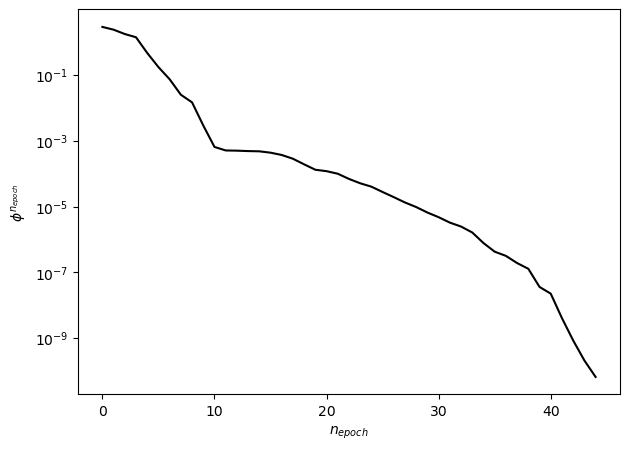

In [28]:
#solver.plot_solution();
solver.plot_loss_history();

In [29]:
test_data=tf.linspace(0.0, 0.0280, 281)
test_data = tf.reshape(test_data,shape=(-1,1))

In [30]:
print(model.call(test_data))

tf.Tensor(
[[-5.72143839e-05 -6.87770677e-04  9.04292260e-04  1.50098398e+00
   1.08740861e+00]
 [-5.64130009e-05 -6.73357946e-04  8.89772389e-04  1.50100246e+00
   1.08739229e+00]
 [-5.56133877e-05 -6.58945610e-04  8.75252776e-04  1.50102095e+00
   1.08737597e+00]
 ...
 [ 9.70875143e-05  3.30285513e-03 -3.12091575e-03  1.50609461e+00
   1.08285054e+00]
 [ 9.73934083e-05  3.31714810e-03 -3.13534896e-03  1.50611289e+00
   1.08283408e+00]
 [ 9.76975106e-05  3.33144060e-03 -3.14978181e-03  1.50613117e+00
   1.08281761e+00]], shape=(281, 5), dtype=float64)
